In [1]:
input_dim = 13
num_clusters = 8
num_classes = 2

model_file = "/home/gregory/Desktop/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt"

import csv
import json
import numpy as np
import os
import pandas as pd


import sys
sys.path.insert(0, "../Code/")
from explain_cs import explain
from load_scvis import load_vae
from metrics import metrics, eval_epsilon
from myplot import plot_polys, plot_groups, plot_metrics, plot_explanation
from misc import poly2labels

def load_model(input_dim = input_dim, model_file = model_file):
    return load_vae(input_dim, model_file)


In [2]:
# Load Data & Configuration

x = pd.read_csv("Data/X.tsv", sep="\t").values

y = pd.read_csv("Data/y.tsv", sep="\t").values


with open("vertices.json") as json_file:  
    all_vertices = json.load(json_file)


In [3]:
# Calculate Data Representation

sess, rep, X, D = load_model()

data_rep = sess.run(rep, feed_dict={X: x, D: np.zeros((1, input_dim))})

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


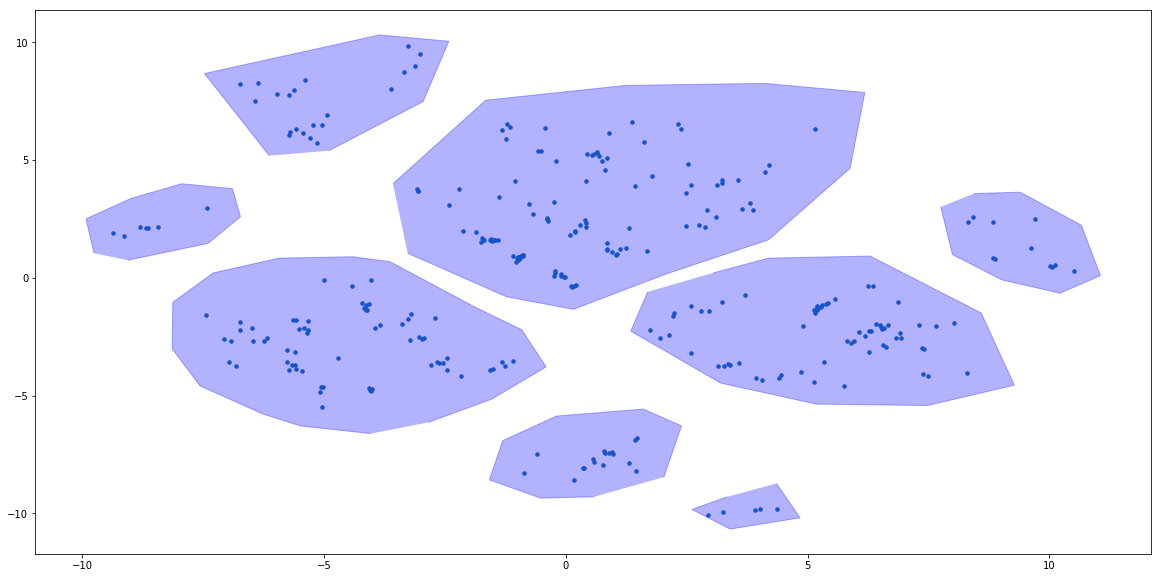

In [4]:
# Visualize the data and the marked clusters

plot_polys(data_rep, all_vertices)

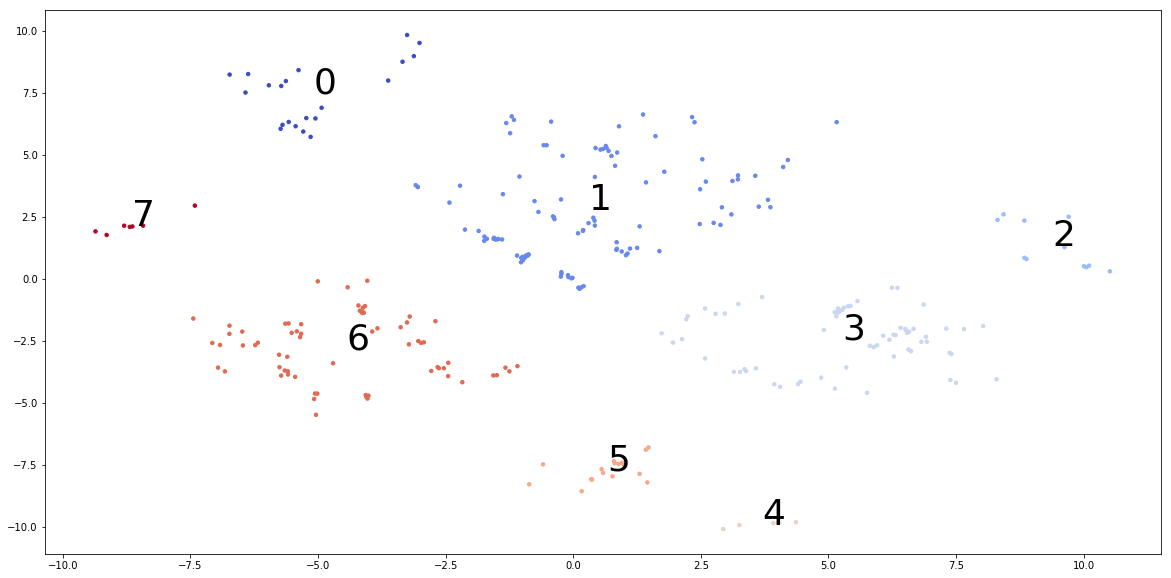

In [5]:
# Visualize the clusters in the learned representation

labels = poly2labels(data_rep, all_vertices)

means, centers, indices = plot_groups(x, data_rep, num_clusters, labels, name = "heart-rep.png")


In [6]:
# Inspect the correlation between cluster and class

confusion  = np.zeros((num_clusters, num_classes))
for i in range(y.shape[0]):
    if labels[i] != -1.0:
        confusion[int(labels[i]), int(y[i])] += 1
    
print(confusion)

[[ 6. 15.]
 [46. 62.]
 [10.  1.]
 [52. 14.]
 [ 4.  1.]
 [10.  7.]
 [ 8. 59.]
 [ 2.  5.]]


In [7]:
# Set epsilon for our metrics

epsilon = 1.0

if True:
    eval_epsilon(load_model, x, indices, epsilon)


INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


In [8]:
# Compute the group explanations

best_val = 0.0
for i in range(5):
    deltas = explain(load_model, means, centers, learning_rate = 0.01, consecutive_steps = 5, lambda_global = 2.0)
    a, b = metrics(load_model, x, indices, deltas, epsilon)
    
    val = np.mean(a)
    
    if val > best_val:
        best_val = val
        np.save("deltas.npy", deltas)
    
    os.system("rm -rf explanation")

                    

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dime

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


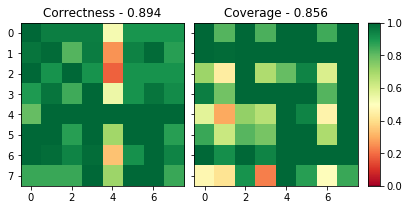

In [9]:
# Evaluate the explanations

deltas = np.load("deltas.npy")

a, b = metrics(load_model, x, indices, deltas, epsilon)

plot_metrics(a, b, name = "heart-metrics.png")


INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


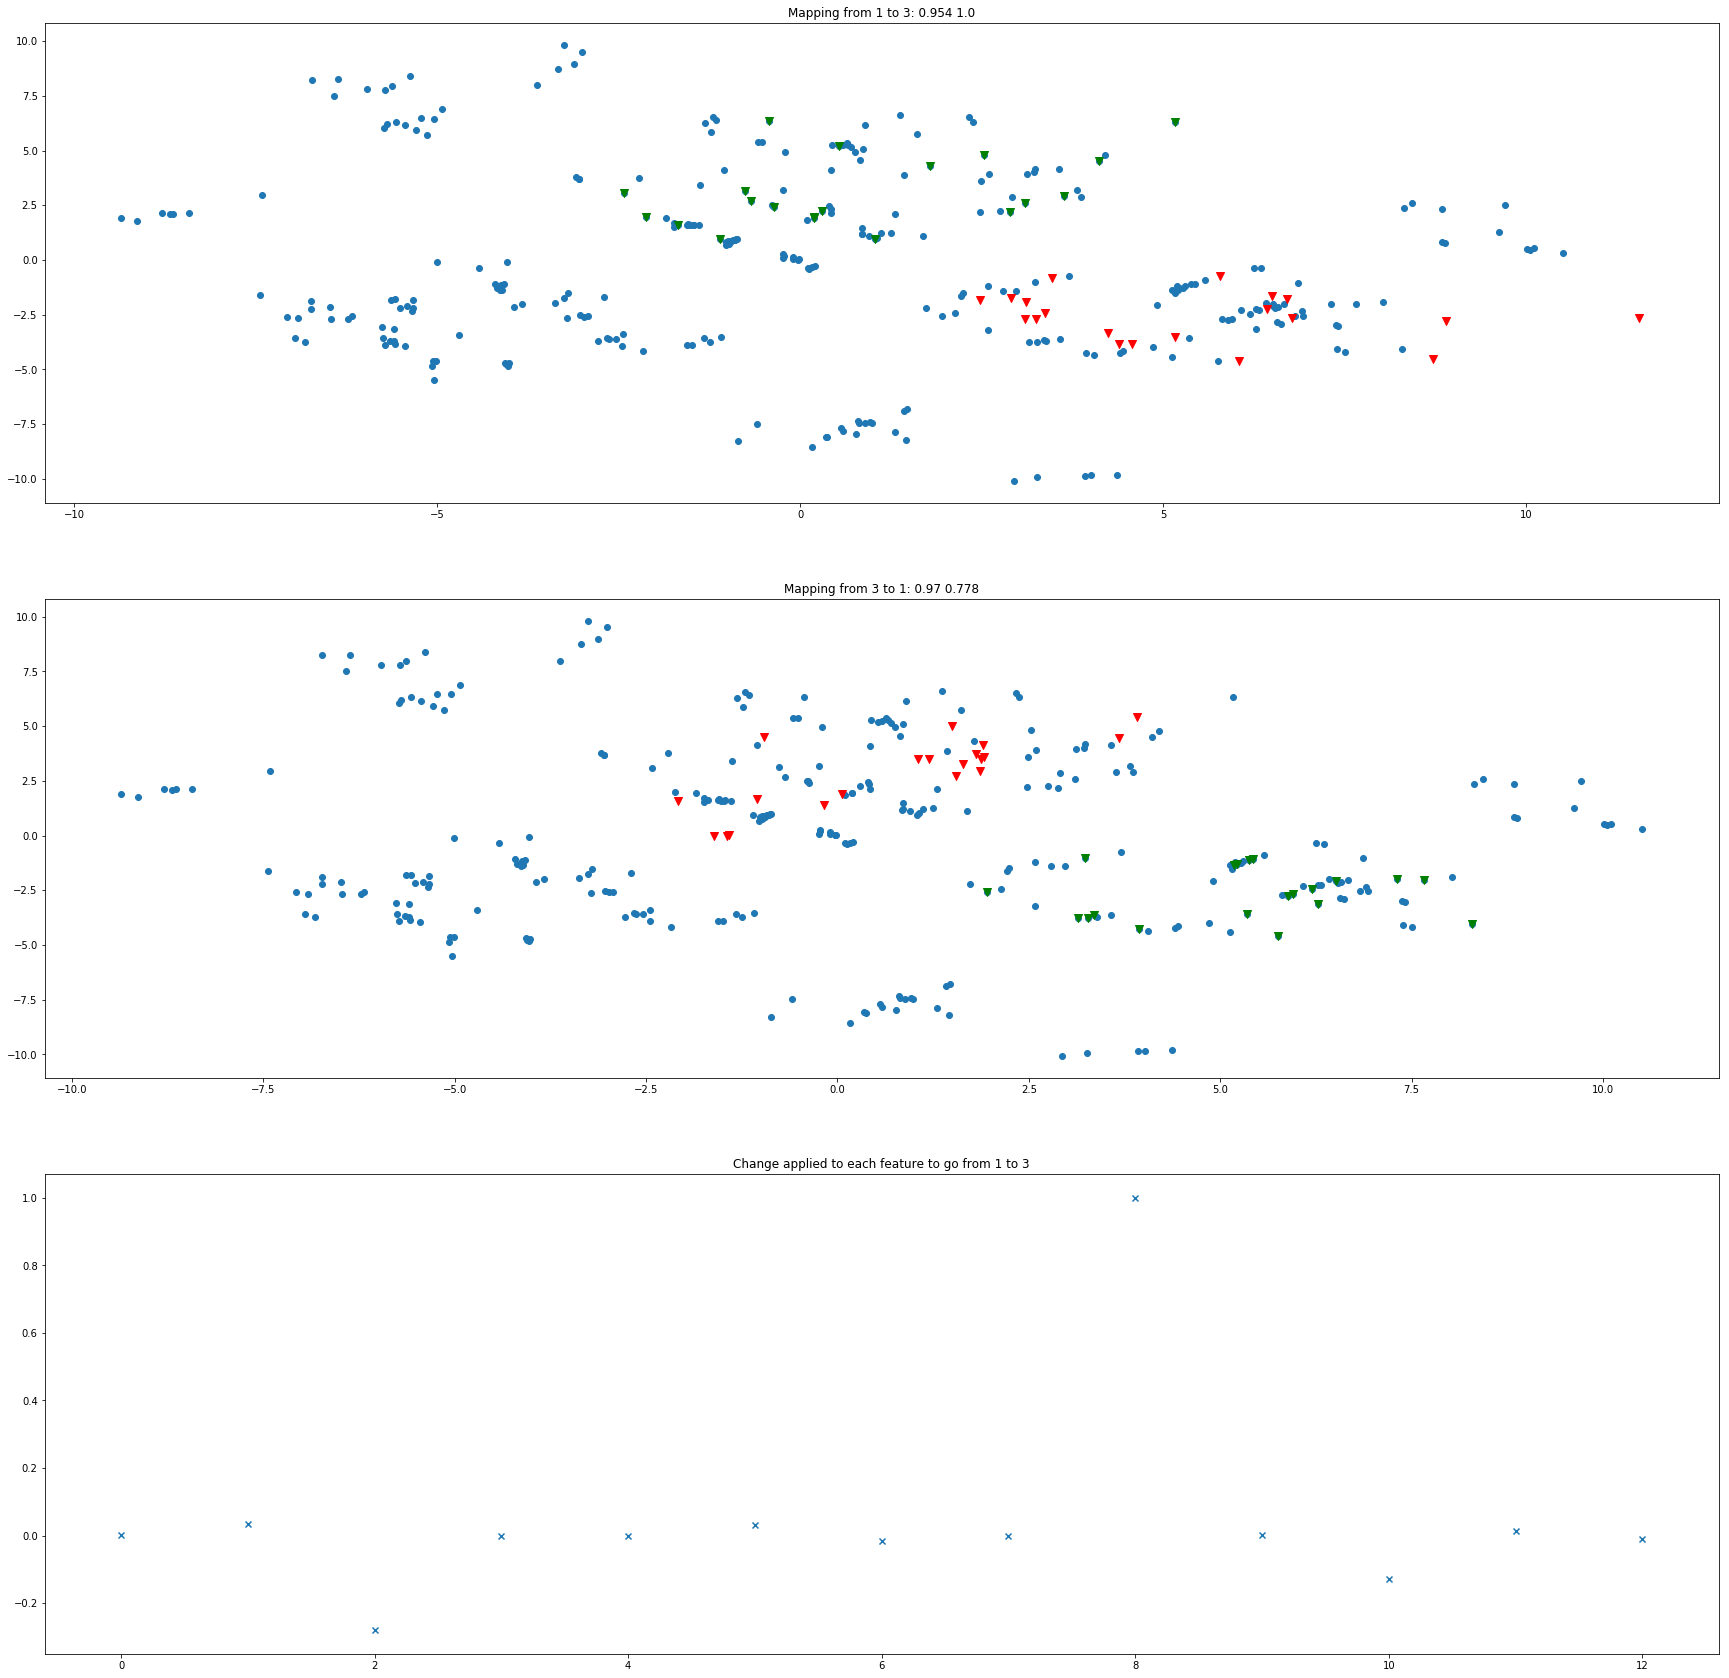

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


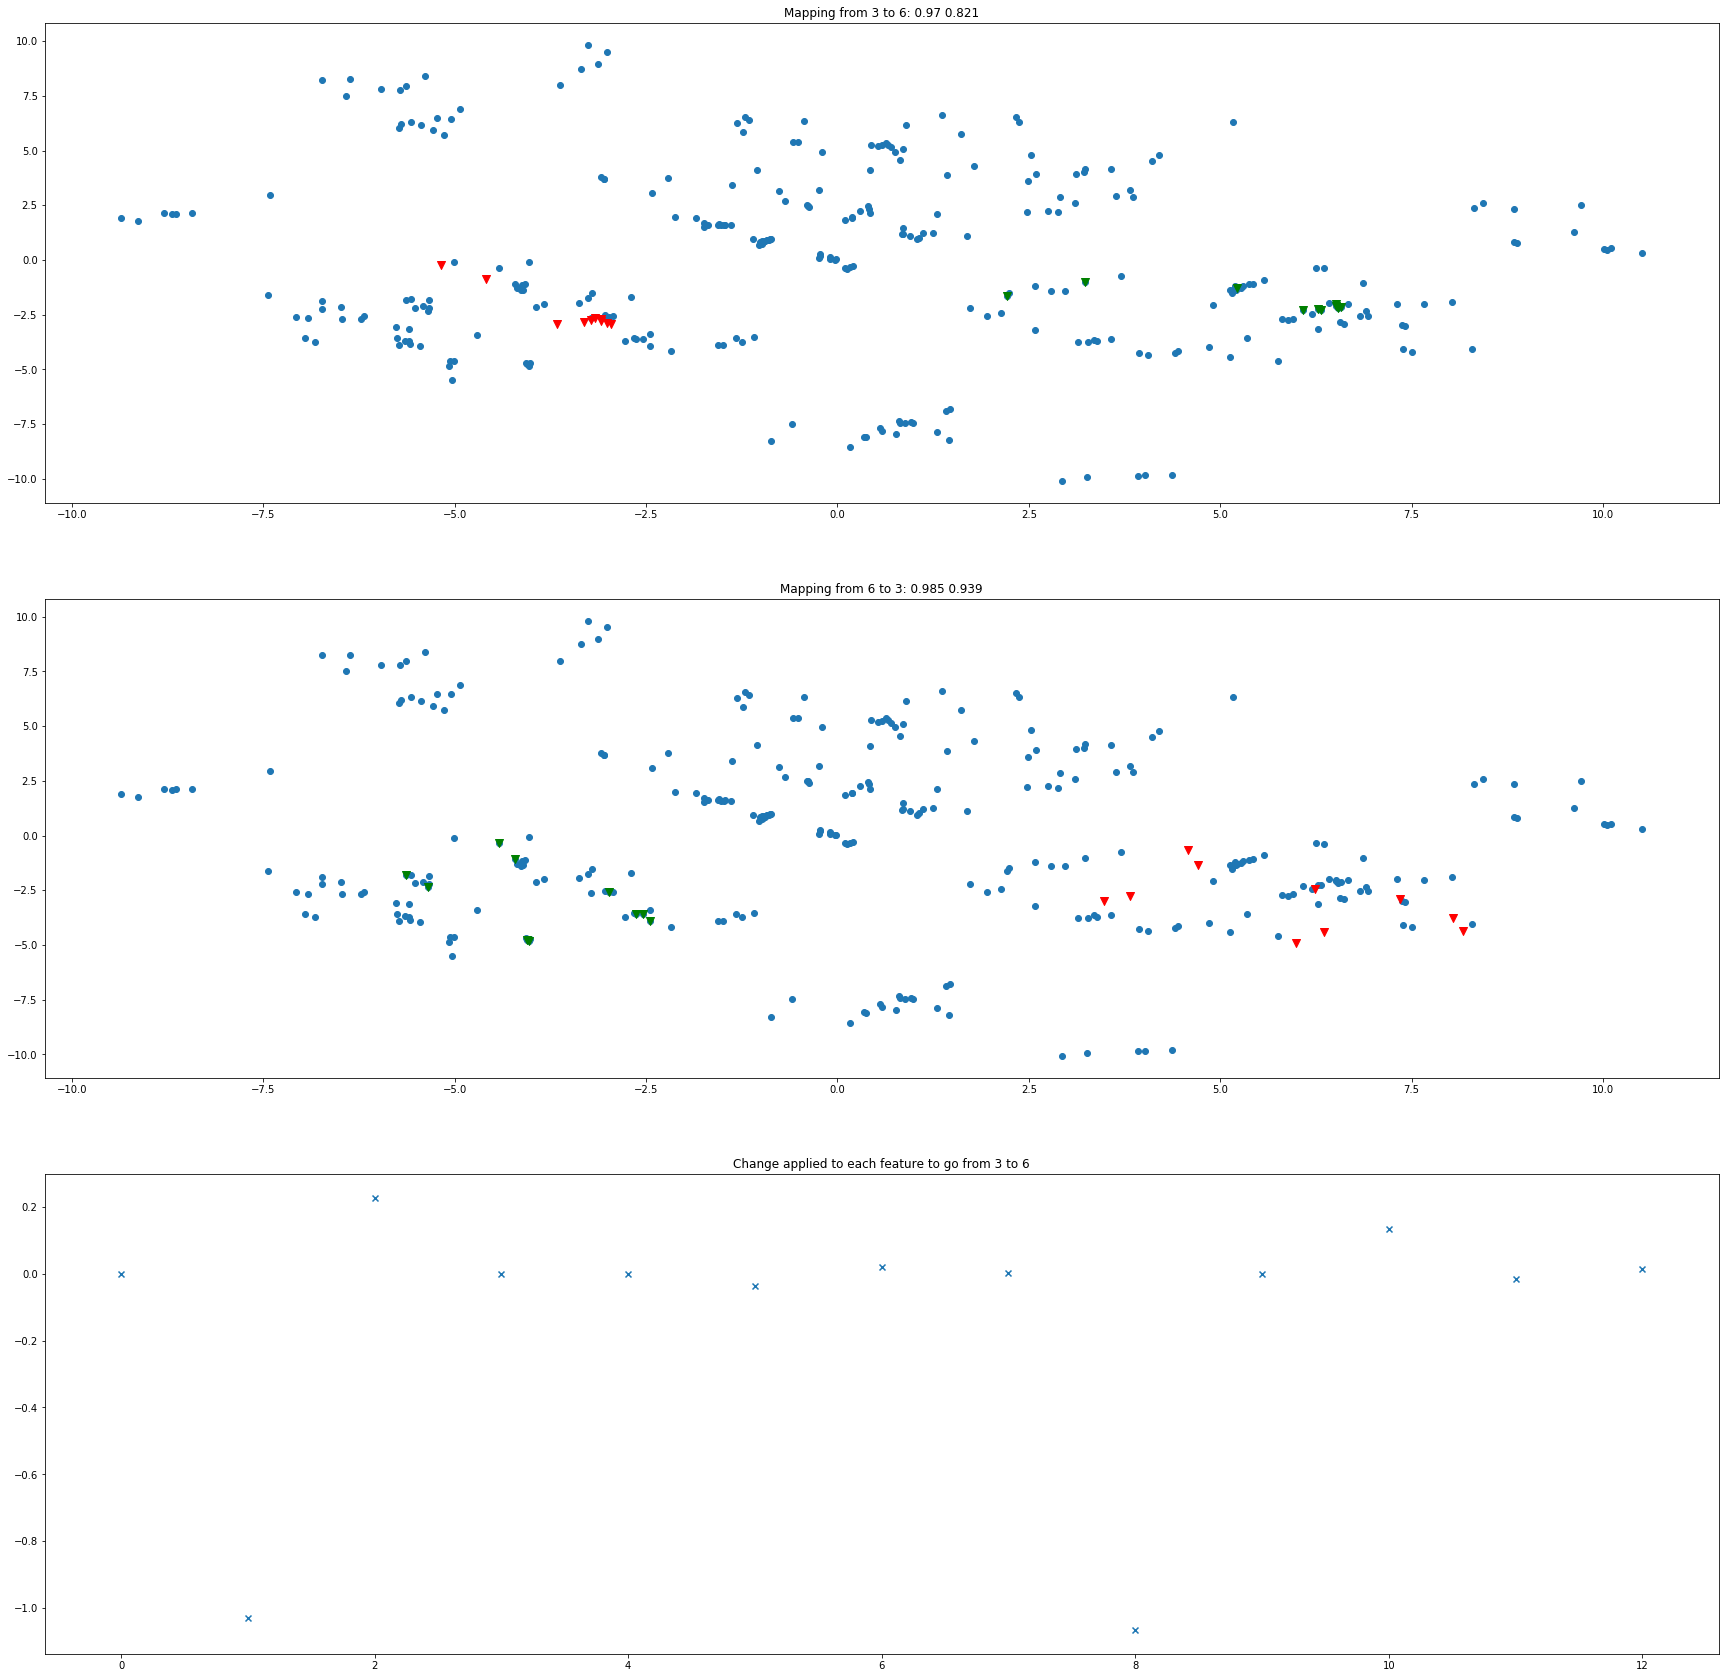

In [10]:
# Visualize the group explanations


plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 1, 3, name = "heart-1to3.png", num_points = 20)

plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 3, 6, name = "heart-3to6.png", num_points = 10)


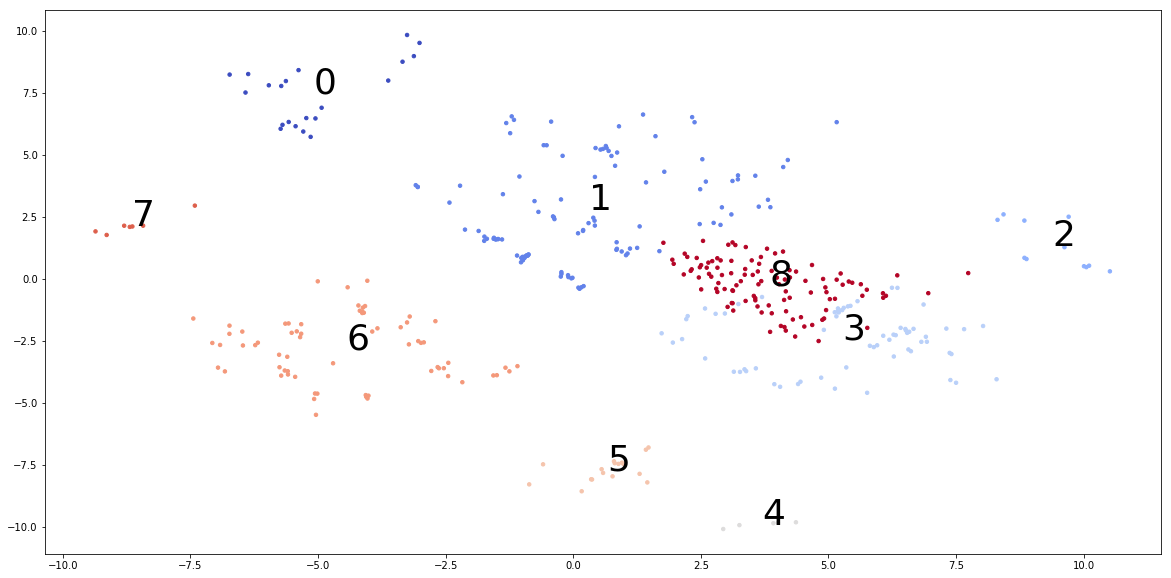

In [25]:
# Let's "corrupt" one of the groups

target_corrupted = 1

indices_corrupted = np.where(labels == target_corrupted)
n_corrupted = len(indices_corrupted[0])

x_corrupted = x[indices_corrupted]
x_corrupted[:, 6] -= 0.9 + np.random.uniform(low = -0.1, high = 0.1, size = n_corrupted)
x_corrupted[:, 8] += 0.6 + np.random.uniform(low = -0.1, high = 0.1, size = n_corrupted)

x_full = np.vstack((x, x_corrupted))

np.savetxt("Data/X_corrupted.tsv", x_full, delimiter = "\t")

labels_full = np.vstack((np.expand_dims(labels, 1), num_clusters * np.ones((n_corrupted,1))))

np.savetxt("Data/labels_corrupted.tsv", labels_full, delimiter = "\t")

# Compute the new representation
data_rep_full = sess.run(rep, feed_dict={X: x_full, D: np.zeros((1, input_dim))})

# Visualize the clusters in the learned representation
means_full, centers_full, indices_full = plot_groups(x_full, data_rep_full, num_clusters + 1, labels_full, name = "heart-rep-corrupted.png")



In [26]:
# Compute the group explanations

best_val = 0.0
for i in range(5):
    deltas = explain(load_model, means_full, centers_full, learning_rate = 0.01, consecutive_steps = 5, lambda_global = 1.5)
    a, b = metrics(load_model, x_full, indices_full, deltas, epsilon)
    
    val = np.mean(a)
    
    if val > best_val:
        best_val = val
        np.save("deltas_corrupted.npy", deltas)
    
    os.system("rm -rf explanation")

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dime

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


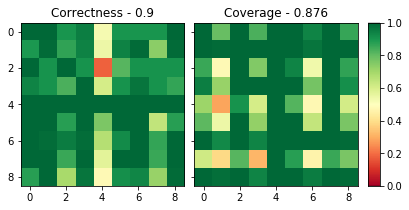

In [27]:
# Evaluate the explanations

deltas = np.load("deltas_corrupted.npy")

a, b = metrics(load_model, x_full, indices_full, deltas, epsilon)

plot_metrics(a, b, name = "heart-metrics-corrupted.png")

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


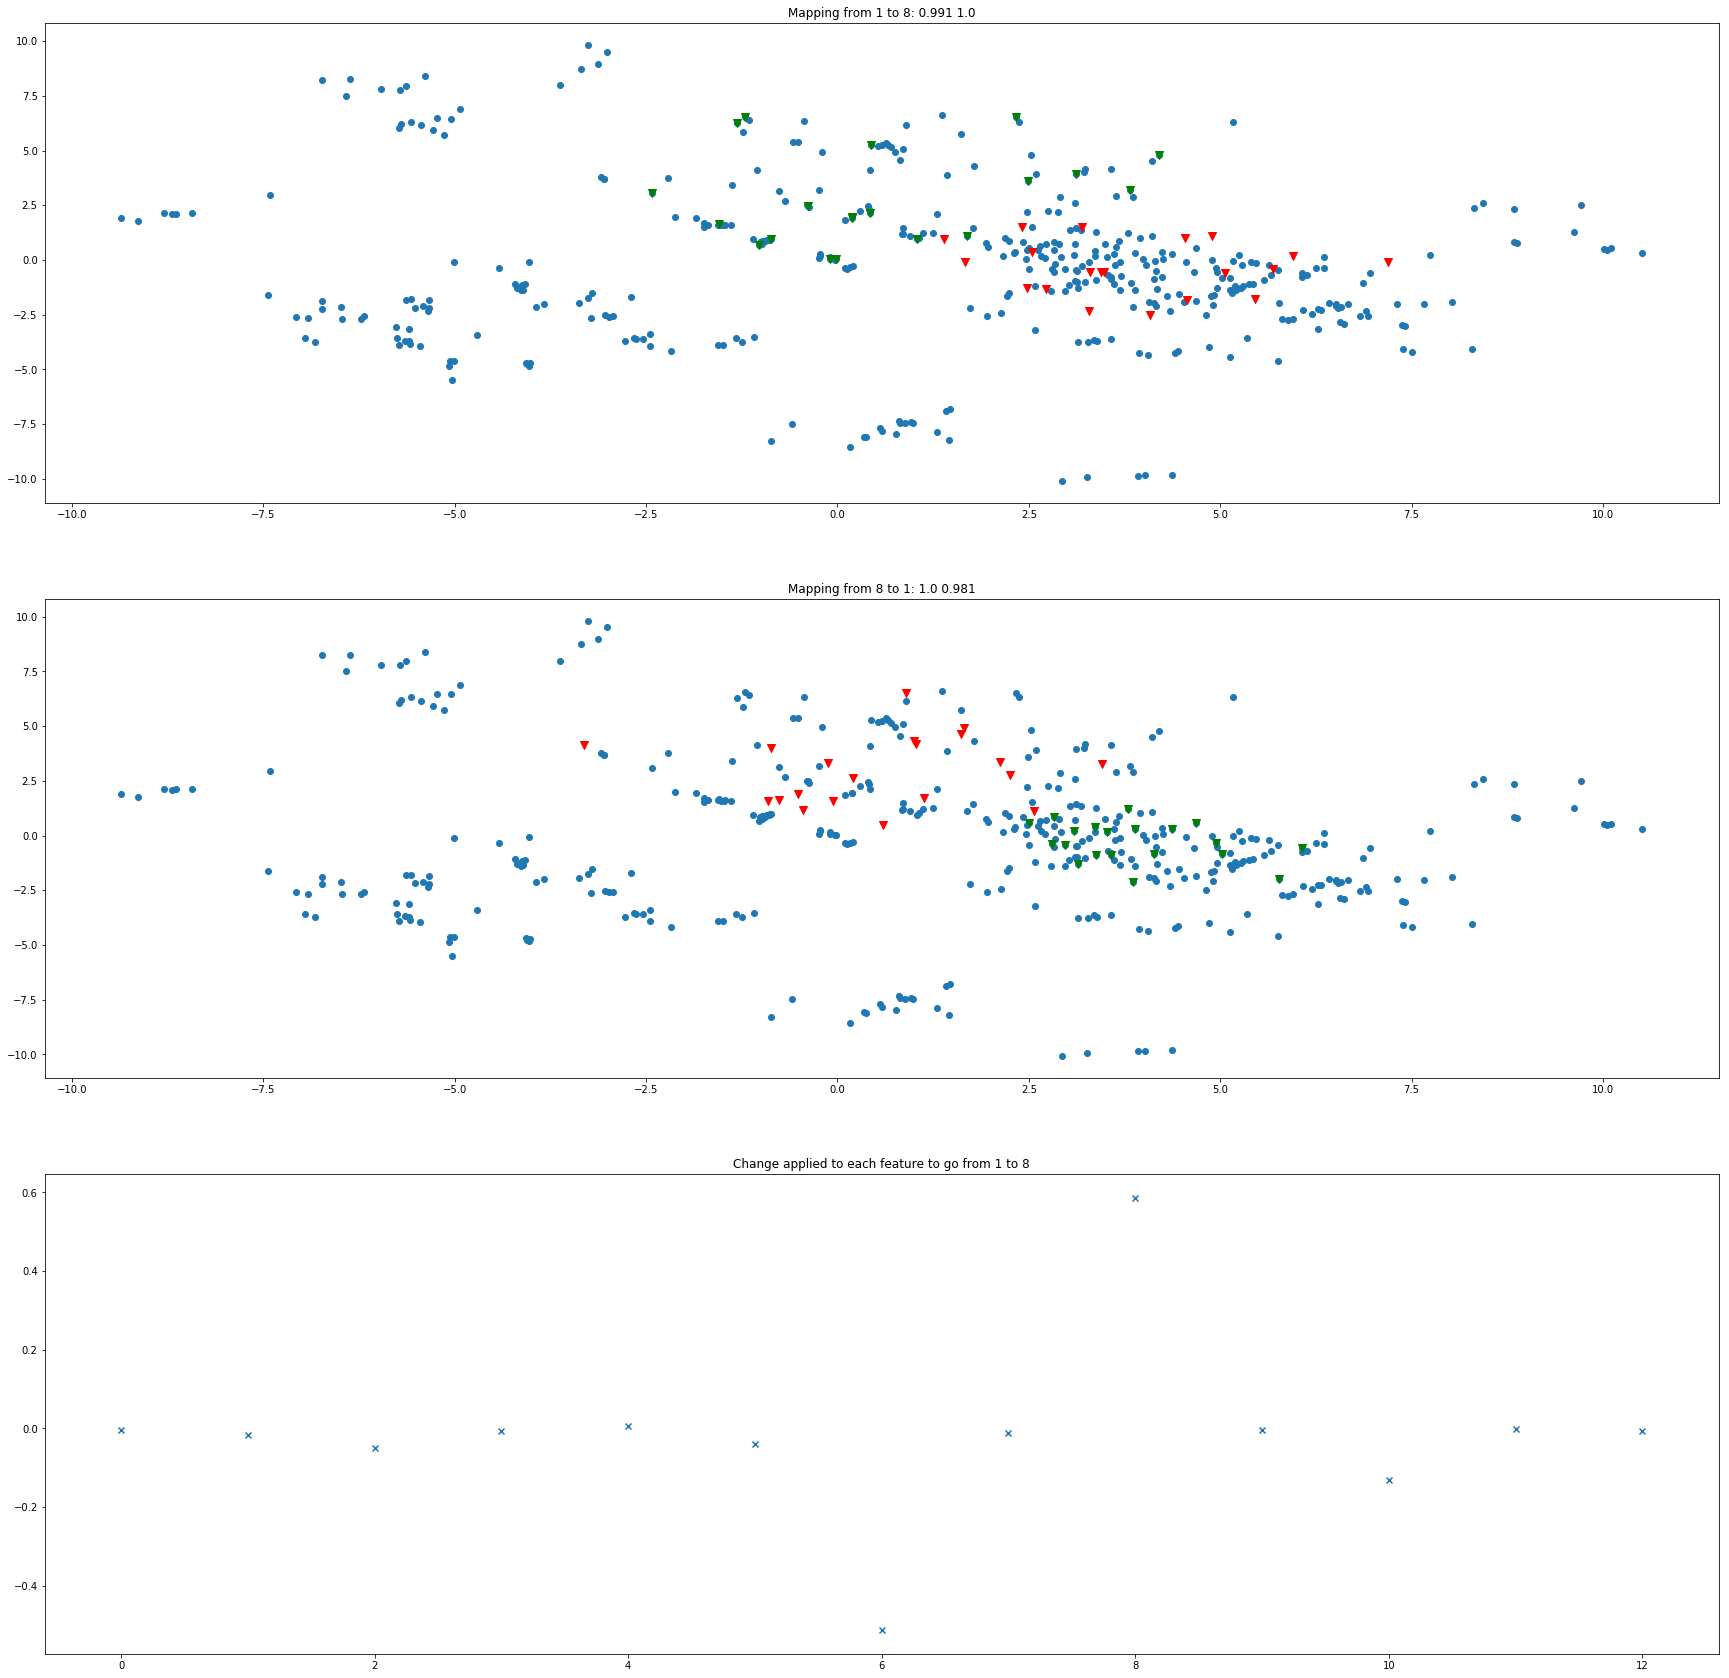

In [28]:
# Check if we found the corruption

plot_explanation(load_model, x_full, data_rep_full, indices_full, deltas, a, b, target_corrupted, num_clusters, name = "heart-t2c.png", num_points = 20)



[[-0.   -0.02 -0.09  0.    0.   -0.96 -0.01  0.    0.06 -0.    0.09 -0.01
  -0.  ]
 [-0.01 -0.02 -0.26 -0.    0.   -0.01 -0.01 -0.01  1.    0.   -0.21  0.03
   0.  ]
 [ 0.    0.02 -0.37 -0.   -0.   -0.93 -0.02  0.    1.06  0.   -0.04 -0.
  -0.01]
 [ 0.01 -0.96 -0.39 -0.   -0.    0.04 -0.07  0.    1.01  0.   -0.15 -0.02
  -0.01]
 [ 0.   -0.96 -0.33 -0.   -0.   -0.96 -0.01  0.    0.99 -0.   -0.01 -0.01
  -0.  ]
 [-0.   -1.01 -0.15 -0.   -0.   -0.97 -0.    0.   -0.01 -0.    0.1  -0.02
   0.  ]
 [-0.   -0.98 -0.01  0.    0.    0.01  0.   -0.   -0.04 -0.    0.15 -0.01
  -0.  ]]
[[-0.   -0.02 -0.1  -0.03 -0.   -0.96 -0.01  0.   -0.02  0.    0.12 -0.02
  -0.  ]
 [ 0.   -0.02 -0.39 -0.04  0.    0.01 -0.06 -0.01  0.92  0.   -0.22 -0.
  -0.01]
 [ 0.    0.03 -0.41 -0.04 -0.   -0.93 -0.02  0.    1.02  0.   -0.04  0.
  -0.  ]
 [ 0.01 -0.93 -0.52 -0.03 -0.01 -0.03 -0.01  0.01  0.97  0.18 -0.02 -0.02
   0.01]
 [-0.   -0.96 -0.39 -0.03  0.   -0.96 -0.02 -0.    0.93 -0.   -0.   -0.02
  -0.  ]
 [ 0.   -

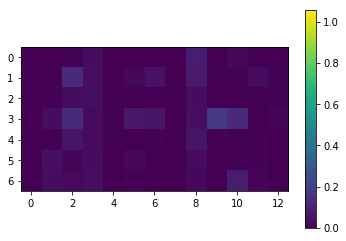

In [29]:
# Evaluate how much the other explanations changed

deltas_original = np.load("deltas.npy")

print(np.round(deltas_original, 2))
print(np.round(deltas[:num_clusters - 1, ], 2))

diff = np.abs(deltas_original - deltas[:num_clusters - 1, ])

import matplotlib.pyplot as plt

plt.imshow(diff, vmin = 0.0, vmax = np.max(np.abs(deltas_original)))
plt.colorbar()
plt.show()
plt.close()